<a href="https://colab.research.google.com/github/siliconshells/Explainable-AI/blob/main/week_6_explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leonard Eshun
### Explainable Deep Learning

This notebook demonstrates the application of various explainability techniques on a pre-trained ResNet-50 model using butterfly images. The techniques showcased include Grad-CAM, HiRes-CAM, and Score-CAM. ResNet is a widely used convolutional neural network architecture known for its deep layers and skip connections, which help mitigate the vanishing gradient problem. It is one of the most popular and capable architectures for image classification tasks, including butterfly classification.

### Motivation
Some butterflies are indicators of the health of an ecosystem. They are also important pollinators, and a food source for other animals in the food chain. This makes them important for maintaining biodiversity. Finally, butterflies are simply beautiful creatures that bring joy to many people.     
This assignment helps to understand how different CAM explainability techniques can be applied to deep learning models, and how they can provide insights into model predictions. In this case, the ResNet-50 Classifier is used to classify images of butterflies, and the explainability techniques help to visualize which parts of the images are most important for the model's predictions. Overall, it helps to know how to better train and explain deep learning models for image classification tasks.

In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### 1. Import Libraries

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from urllib.request import urlopen

# Model
from torchvision.models import resnet50

# CAM utilities
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    HiResCAM,
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### 2. Modeling and Explainability

Explaining predicted class: monarch (idx 323)


100%|██████████| 128/128 [05:05<00:00,  2.39s/it]


Explaining predicted class: lycaenid (idx 326)


100%|██████████| 128/128 [04:22<00:00,  2.05s/it]


Explaining predicted class: lycaenid (idx 326)


100%|██████████| 128/128 [03:54<00:00,  1.83s/it]


Explaining predicted class: ringlet (idx 322)


100%|██████████| 128/128 [04:20<00:00,  2.04s/it]


Explaining predicted class: lacewing (idx 318)


100%|██████████| 128/128 [04:04<00:00,  1.91s/it]


Explaining predicted class: admiral (idx 321)


100%|██████████| 128/128 [04:53<00:00,  2.29s/it]


Explaining predicted class: admiral (idx 321)


100%|██████████| 128/128 [04:17<00:00,  2.01s/it]


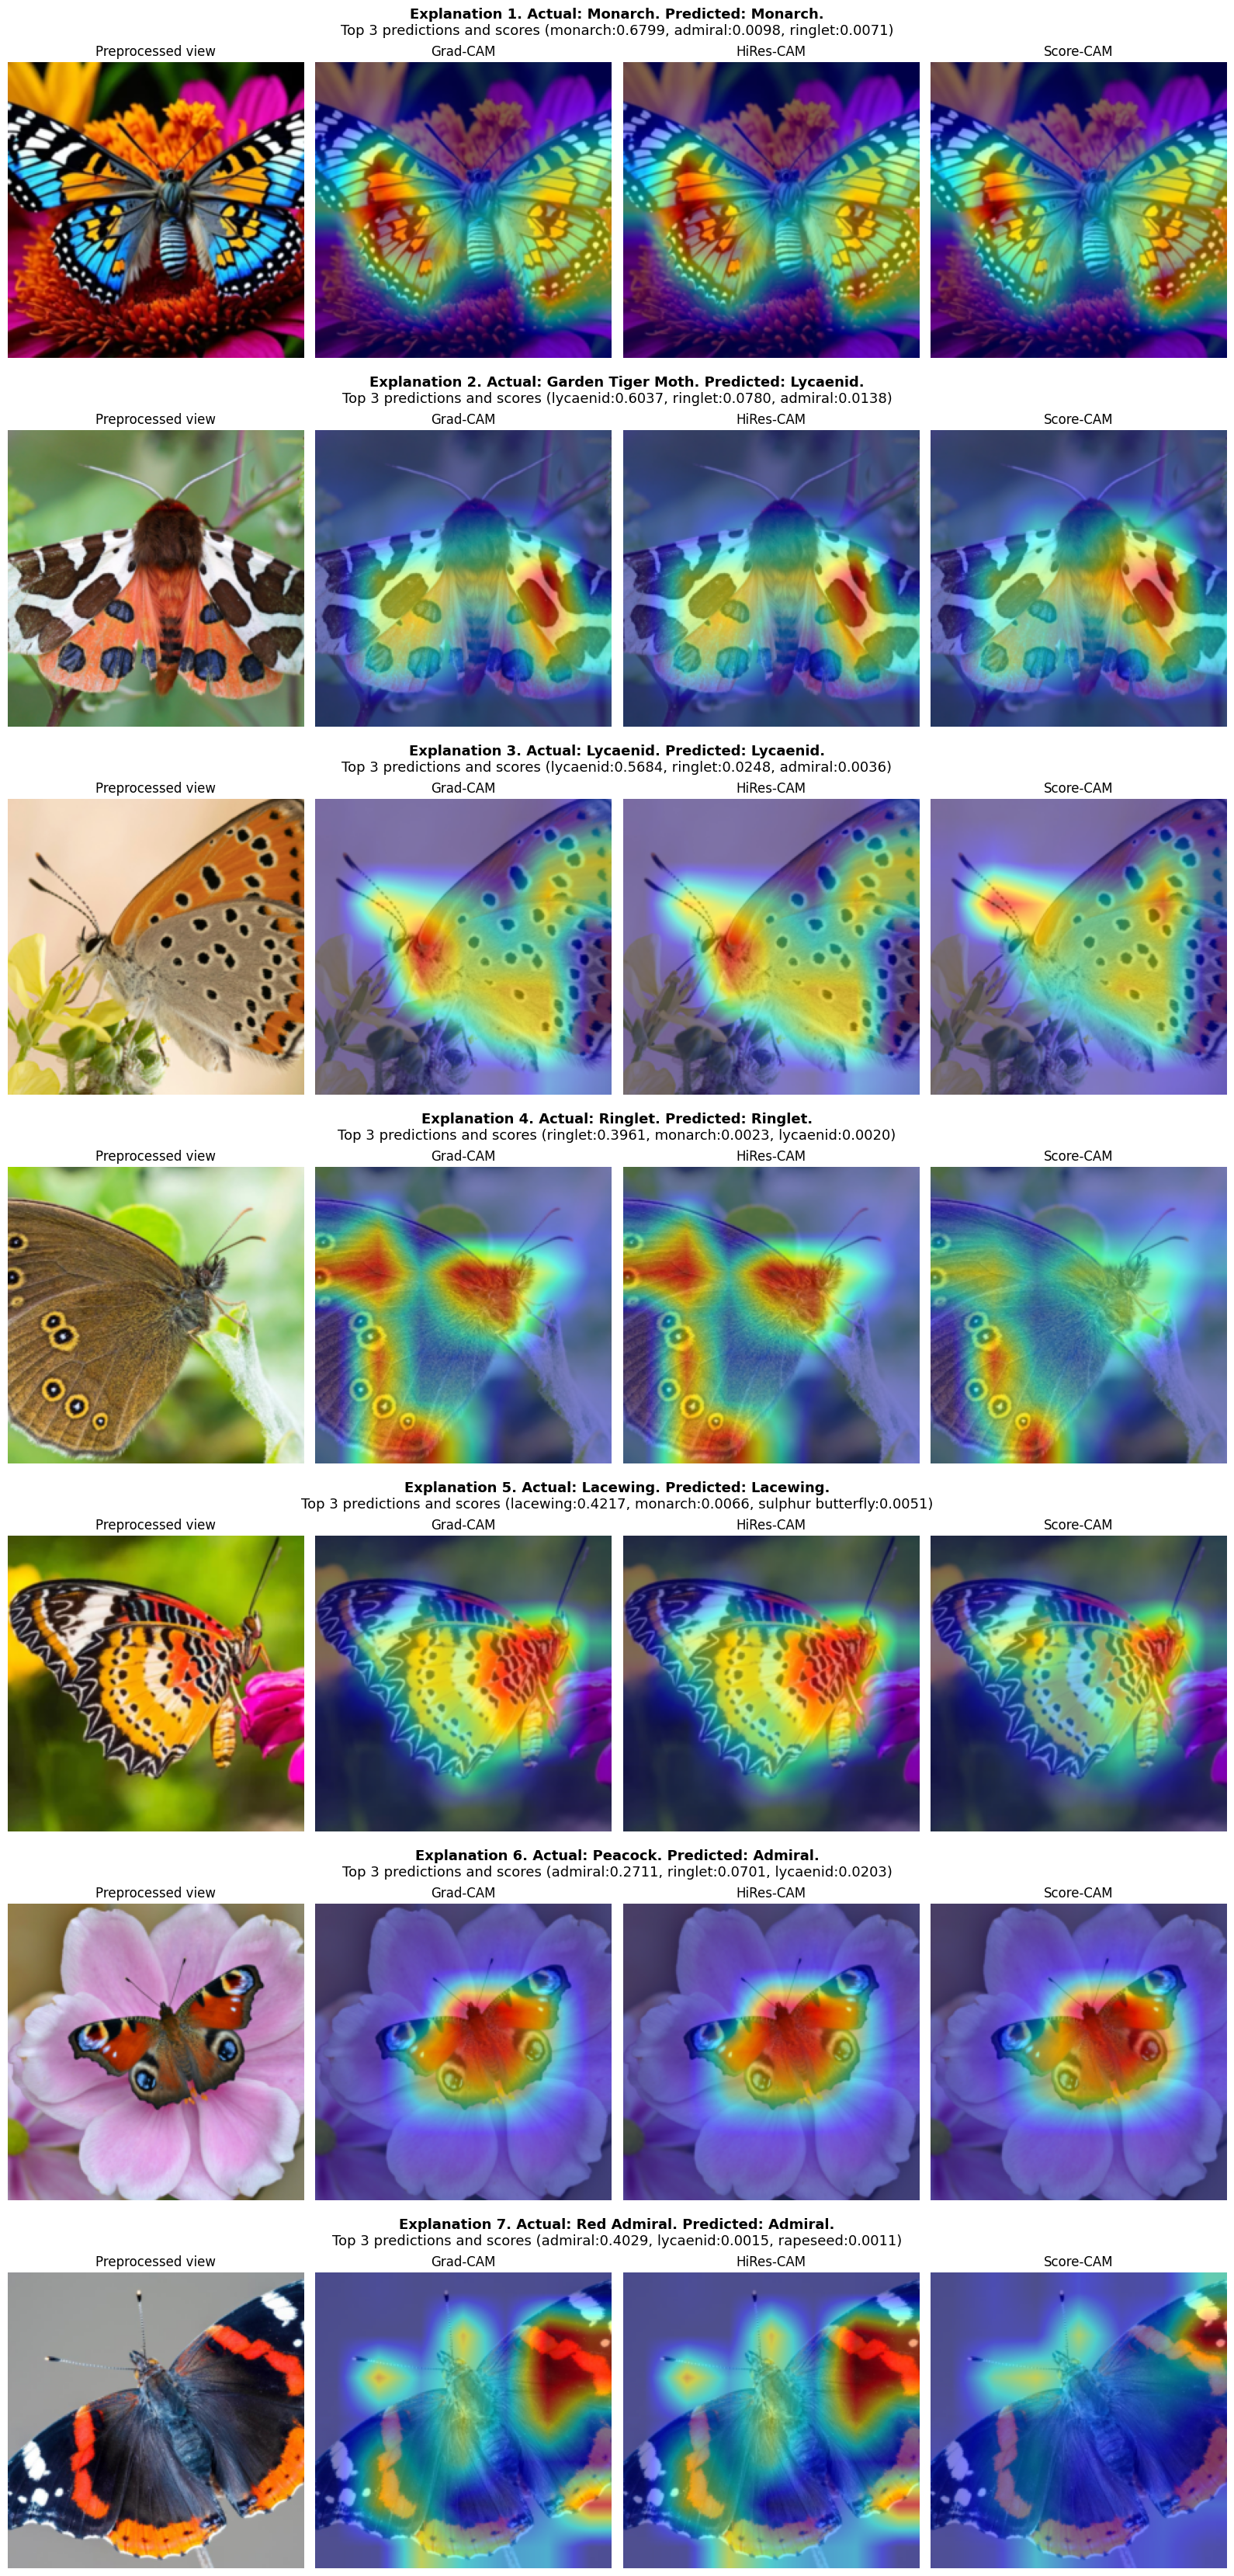

In [ ]:
"""
I used ChatGPT 5 to generate the code for one explanation (the Grad-CAM) with one image
on 15-Oct-2025 8:33 AM and I built upon it to generate the other two GradCAM variants after
trying multiple variants. I also built the section responsible for plotting the images in a grid after trying multiple
images with varying results.
PLEASE NOTE: The ScoreCAM takes 31 minutes to run.
"""
# Using weights if available
try:
    from torchvision.models import ResNet50_Weights

    try:
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).eval()
    except Exception:
        model = resnet50(weights=ResNet50_Weights.DEFAULT).eval()

    try:
        categories = ResNet50_Weights.IMAGENET1K_V2.meta["categories"]
    except Exception:
        try:
            categories = ResNet50_Weights.DEFAULT.meta["categories"]
        except Exception:
            categories = None
except Exception:
    model = resnet50(pretrained=True).eval()
    categories = None

# Manual, version-safe preprocess for the model
preprocess = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Visualization transform: Keeping PIL -> numpy in [0,1]
vis_transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
    ]
)

# Plot
fig, axes = plt.subplots(7, 4, figsize=(16, 35))

butterfly_types = [
    "Monarch",
    "Garden Tiger Moth",
    "Lycaenid",
    "Ringlet",
    "Lacewing",
    "Peacock",
    "Red Admiral",
]
predicted_types = []
subplot_titles = []

for row in range(7):
    # Loading the image
    url = f"https://raw.githubusercontent.com/siliconshells/Explainable-AI/main/butterfly{row}.png"

    # img_path = f"butterfly{row}.png"
    # pil_img = Image.open(img_path).convert("RGB")

    pil_img = Image.open(urlopen(url)).convert("RGB")

    # Building overlay base (same spatial size as model input)
    vis_pil = vis_transform(pil_img)
    rgb_vis = np.array(vis_pil).astype(np.float32) / 255.0  # HxWx3 in [0,1]

    # Model input tensor
    input_tensor = preprocess(pil_img).unsqueeze(0)

    # Predicting the class to explain
    with torch.no_grad():
        logits = model(input_tensor)
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(torch.argmax(probs))
    pred_name = categories[pred_idx] if categories else f"class_{pred_idx}"
    print(f"Explaining predicted class: {pred_name} (idx {pred_idx})")

    targets = [ClassifierOutputTarget(pred_idx)]
    use_cuda = torch.cuda.is_available()
    target_layers = [model.layer4[-1]]

    # Grad-CAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        cam_map = cam(input_tensor=input_tensor, targets=targets)[0]  # 224x224, [0,1]
        gradcam_vis = show_cam_on_image(rgb_vis, cam_map, use_rgb=True)

    # HiRes-CAM
    with HiResCAM(model=model, target_layers=target_layers) as campp:
        campp_map = campp(input_tensor=input_tensor, targets=targets)[0]
        gradcampp_vis = show_cam_on_image(rgb_vis, campp_map, use_rgb=True)

    # Score-CAM
    with ScoreCAM(model=model, target_layers=target_layers) as sc:
        sc_map = sc(input_tensor=input_tensor, targets=targets)[0]
        scorecam_vis = show_cam_on_image(rgb_vis, sc_map, use_rgb=True)

    axes[row, 0].imshow(vis_pil)
    axes[row, 0].set_title("Preprocessed view")
    axes[row, 0].axis("off")
    axes[row, 1].imshow(gradcam_vis)
    axes[row, 1].set_title("Grad-CAM")
    axes[row, 1].axis("off")
    axes[row, 2].imshow(gradcampp_vis)
    axes[row, 2].set_title("HiRes-CAM")
    axes[row, 2].axis("off")
    axes[row, 3].imshow(scorecam_vis)
    axes[row, 3].set_title("Score-CAM")
    axes[row, 3].axis("off")

    top_5_predictions = ""
    top5 = torch.topk(probs, k=3)

    for p, cls_idx in zip(top5.values.tolist(), top5.indices.tolist()):
        name = categories[cls_idx] if categories else f"class_{cls_idx}"
        top_5_predictions += f"{name}:{p:.4f}, "

    subplot_titles.append(top_5_predictions)
    predicted_types.append(
        f"Explanation {row + 1}. Actual: {butterfly_types[row]}. Predicted: {pred_name.capitalize()}."
    )
    plt.tight_layout()

# Adding central row titles
for row in range(7):
    fig.text(
        0.5,
        axes[row, 0].get_position().y1 + 0.02,
        predicted_types[row],
        ha="center",
        va="top",
        fontsize=13,
        fontweight="bold",
    )
    fig.text(
        0.5,
        axes[row, 0].get_position().y1 + 0.014,
        f"Top 3 predictions and scores ({subplot_titles[row].strip().strip(',')})",
        ha="center",
        va="top",
        fontsize=13,
        fontweight="regular",
    )

plt.show()

### 3. Discussion and Conclusion

I repeated the test for the misclassified butterflies to understand what could have caused the misclassification. There wasn't a lot of difference between the GradCAM, HiResCAM and ScoreCAM. However, it seems GradCAM was able to give sufficiently more information in the heatmap than ScoreCAM. The output for HiResCAM was almost identical to GradCAM.      

In general, it seems that the model attends to the wings of the butterflies, which is expected since the wings are often the most distinctive feature of butterflies. In images where we have a side view, the model also seems to focus on the head of the butterfly, which is also expected since the head can also have distinctive features. Therefore, it seems that the model is attending to the correct visual cues in order to make its predictions. It was able to attend to the relevant portions of the Monach Butterfly's wings, despite the busy background. However, the challenge is when it comes to distinguishing between different species of butterflies that can be very similar in appearance, and all it has is the the winds (top view). In these cases, the model struggled to attend to the correct visual cues, leading to misclassifications.         

The particular case of the Peacock butterfly is a good example, as it misclassified it as an Admiral butterfly. This is likely because it focused on the red patch on the wings, which is a common feature of both species. However, the model may have missed the very glaring distinctive features of the Peacock butterfly, such as the big eye shapes in the wings. It's quite clear from the heatmap that it didn't focus intensely on the four eye shapes.    

There was a similar case with the Garden Tiger moth, which was misclassified as a Lycaenid butterfly. This is likely because the model focused on the black patches on the wings, which are common features of both species. However, the model missed the distinctive features of the Garden Tiger moth, such as the white and orange colored areas on the wings. It should have also noticed that the sizes are different with the Garden Tiger having relatively very large black patches. It is also possible that the model was trained on a limited number of images of the Garden Tiger moth, which could have led to poor generalization to new images, or the particular Garden Moth species used for training were different in appearance from this one I'm using for inference.      

This highlights the importance of model explainability, as it allows us to understand how the model is making its predictions, and can help us identify potential areas for improvement. It can assist us in the event that we want to retrain the model to give it necessary images, knowing what it attends to, or use a different architecture that may be better suited for distinguishing between similar species.